# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [4]:
USER_NAME = u"Соловьев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \frac{1}{N}\left[\sum_j -y^{(j)}x_i^{(j)} \sigma(-y^{(j)} g(x^{(j)}))\right] + \frac{2}{C}w_i $$

## Имплементация (5 баллов)

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=32):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        batch_size - размер мини-батча
        loss_func - значения функции потерь после каждой эпохи
        epoches - количество ошибок полсе каждой эпохи
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.loss_func = np.empty(max_epoch)
        self.epoches = np.empty(max_epoch)
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        # Добавляем столбец единиц для w0
        Y = np.ones((X.shape[0], X.shape[1] + 1))
        Y[:, :-1] = X
        
        # Инициализируем веса
        self.weights = np.zeros((Y.shape[1]))
        
        # Инициализируем счетчик эпох
        epoches = 0
        
        while True:
            epoches += 1
            alpha = self.alpha / epoches

            # Перемешиваем данные и делим на мини батчи 
            indicies = np.arange(Y.shape[0])
            np.random.shuffle(indicies)
            batches = np.array_split(indicies, Y.shape[0] / self.batch_size + 1)

            # Считаем градиент на каждом мини батче и изменяем веса
            for b in batches:
                self.weights -= alpha*self.grad(Y[b], y[b])
               
            # Подсчитываем количество ошибок и функцию потерь
            error = Y.dot(self.weights)
            error *= y
            
            loss_func = np.log(1 + np.exp(-error))
            loss_func = np.sum(loss_func, axis = 0) / Y.shape[0]
            loss_func += np.sum(np.square(self.weights)) / self.C
            
            error = np.sign(error)
            np.place(error, error > 0, 0)
            
            self.loss_func[epoches-1] = loss_func
            self.epoches[epoches-1] = -np.sum(error)
                
            if epoches == self.max_epoch:
                break
                
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        g = X.dot(self.weights[:-1]) + self.weights[-1]
        y_hat = np.sign(g)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        g = X.dot(self.weights[:-1]) + self.weights[-1]
        y_hat_proba = np.empty((X.shape[0], 2))
        
        y_hat_proba[:, 0:1] = 1/(1 + np.exp(-g))
        y_hat_proba[:, 1:] = 1 - y_hat_proba[:, 0:1]
        
        return y_hat_proba
    
    def grad(self, X, y):
        '''
        Возвращает градиент X
        '''
        
        margin = X.dot(self.weights) * y
        
        grad = 1/(1 + np.exp(margin))
        grad *= -y
        grad = X.T.dot(grad) / X.shape[0] + self.weights * (2/self.C)
        
        return grad

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

[ 0.1599177  -0.00444375 -0.04843628]
[ 127.  123.  123.  123.  123.  123.  123.  123.  123.  123.]


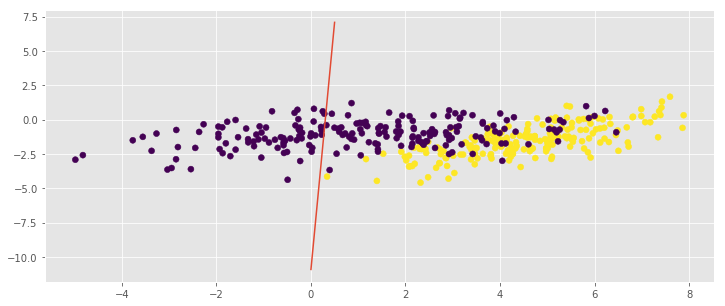

In [26]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), -np.ones(200)]

plt.scatter(X[:,0], X[:,1], c=y)

sgd = MySGDClassifier(alpha=0.1, batch_size=64)
sgd.fit(X, y)
a = sgd.weights
print a

x_g = np.linspace(0, 0.5)
y_g = (-a[2] - a[0]*x_g)/a[1]

print sgd.epoches
plt.plot(x_g, y_g)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [4]:
from sklearn.datasets import make_classification

In [5]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

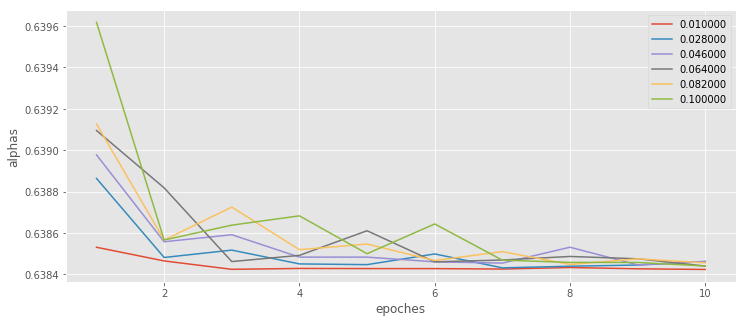

In [18]:
ax = plt.subplot()
ax.set_xlabel("epoches")
ax.set_ylabel("alphas")

legend = []
alphas = np.linspace(0.01, 0.1, 6)
for alpha in alphas:
    sgd = MySGDClassifier(alpha=alpha)
    sgd.fit(X, y)
    
    x_g = np.arange(10) + 1
    y_g = sgd.loss_func
    
    ax.plot(x_g, y_g, label="%f" % alpha)
    
ax.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [ ]:
# При слишком маленьких значениях C в экспоненте происходит переполнение

In [8]:
weights = np.empty((10, 11))
i = 0

x_g = np.logspace(3, -3, 10)
for C in np.logspace(3, -3, 10):
    sgd = MySGDClassifier(C=C)
    sgd.fit(X, y)
    weights[i] = sgd.weights
    i += 1

/home/soloway2010/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: overflow encountered in exp
/home/soloway2010/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in multiply
/home/soloway2010/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in multiply
/home/soloway2010/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


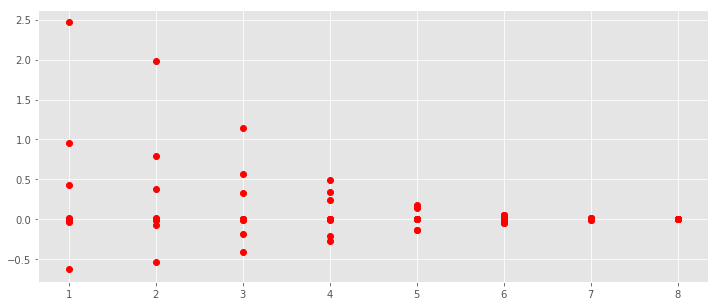

In [11]:
i = 1
for w in weights:
    x_g = np.array([i]*11)
    plt.plot(x_g, w, 'ro')
    i += 1

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here